# Exploratory Data Analysis

## 1: Overview: 

I wanted to explore the financial data of Olist, a Brazilian based e-commerce company. The data was provided via kaggle and contains sales data from 2016-2018. 9 .csv files were provided with information on the products, customers and retailers on the site. I downloaded the .csv files and created a SQL databse using DB Browser for SQLite, which will be queried throughout. I primarly wanted to explore the factors that drive an increase in sales (such as location, quality of product, type of product, etc), and provided some visualizations for them below. 

## 2: Relevant Code for Preparation: 
The next three code chunks are provided to load packages, change formattingin my SQL databse and running a sample SQL code. 

In [2]:
#Import the relevant packages for use. 
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
%matplotlib inline
from matplotlib.ticker import ScalarFormatter

In [3]:
# Code used to make the first row of the SQL data the header row, as there was an error when importing into SQLite.
#conn = sqlite3.connect("Olist_DB.db")
#cursor = conn.cursor()


#cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
#tables = [row[0] for row in cursor.fetchall()]

#for table in tables:
    #cursor.execute(f"SELECT * FROM {table}")
    #first_row = cursor.fetchone()
    
    #if first_row:
        # Get the column names from the first row
        #new_columns = [str(column) for column in first_row]


       # cursor.execute(f"ALTER TABLE {table} RENAME TO {table}_old;")


        #new_columns_definition = ", ".join([f'"{col}" TEXT' for col in new_columns])
        #cursor.execute(f"CREATE TABLE {table} ({new_columns_definition});")
        

        #placeholder = ", ".join(["?" for _ in new_columns])
        #cursor.execute(f"INSERT INTO {table} SELECT * FROM {table}_old WHERE rowid > 1;")
        

        #cursor.execute(f"DROP TABLE {table}_old;")

#conn.commit()
#conn.close()

In [4]:
#Code to run some sample SQL code through a databse connection.

connection_to_database = sqlite3.connect("Olist_DB.db")
cursor = connection_to_database.cursor()

#Example query
cursor.execute(
    "SELECT customer_id FROM olist_customers_dataset LIMIT 10;")

print(cursor.fetchall())


connection_to_database.close()

[('06b8999e2fba1a1fbc88172c00ba8bc7',), ('18955e83d337fd6b2def6b18a428ac77',), ('4e7b3e00288586ebd08712fdd0374a03',), ('b2b6027bc5c5109e529d4dc6358b12c3',), ('4f2d8ab171c80ec8364f7c12e35b23ad',), ('879864dab9bc3047522c92c82e1212b8',), ('fd826e7cf63160e536e0908c76c3f441',), ('5e274e7a0c3809e14aba7ad5aae0d407',), ('5adf08e34b2e993982a47070956c5c65',), ('4b7139f34592b3a31687243a302fa75b',)]


## 3: City Data: 

A SQL query is run to gather data on the total sales and total amount of items sold, broken down by the five cities who ordered the most volumn. Histograms are provided to visualize the data. 

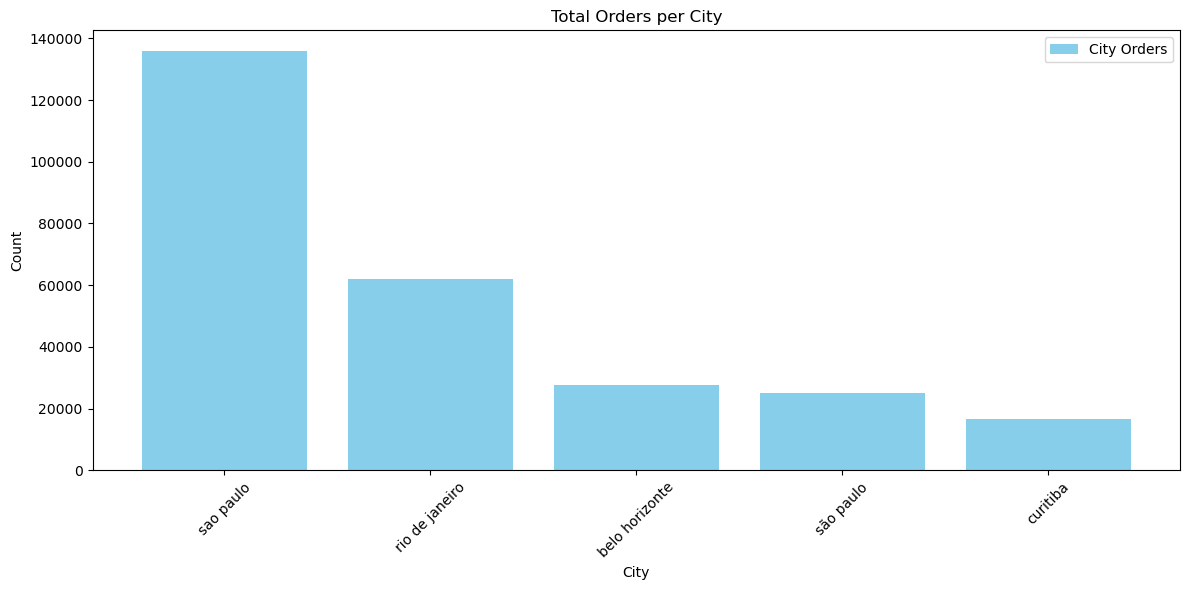

In [5]:
#Connection to database, run query and load data into pandas

connection_to_database = sqlite3.connect("Olist_DB.db")

try:
    orders_by_city_query = """
    SELECT (geolocation_city) AS City, COUNT(*) AS City_Count
    FROM olist_geolocation_dataset
    GROUP BY City
    ORDER BY City_Count DESC
    LIMIT 5
    """
    
    
    orders_by_city = pd.read_sql_query(orders_by_city_query, connection_to_database)
    
#plot the data

    plt.figure(figsize=(12, 6))
    plt.bar(orders_by_city['City'], orders_by_city['City_Count'], color='skyblue', label='City Orders')
    plt.title('Total Orders per City')
    plt.xlabel('City')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
finally:
    connection_to_database.close()

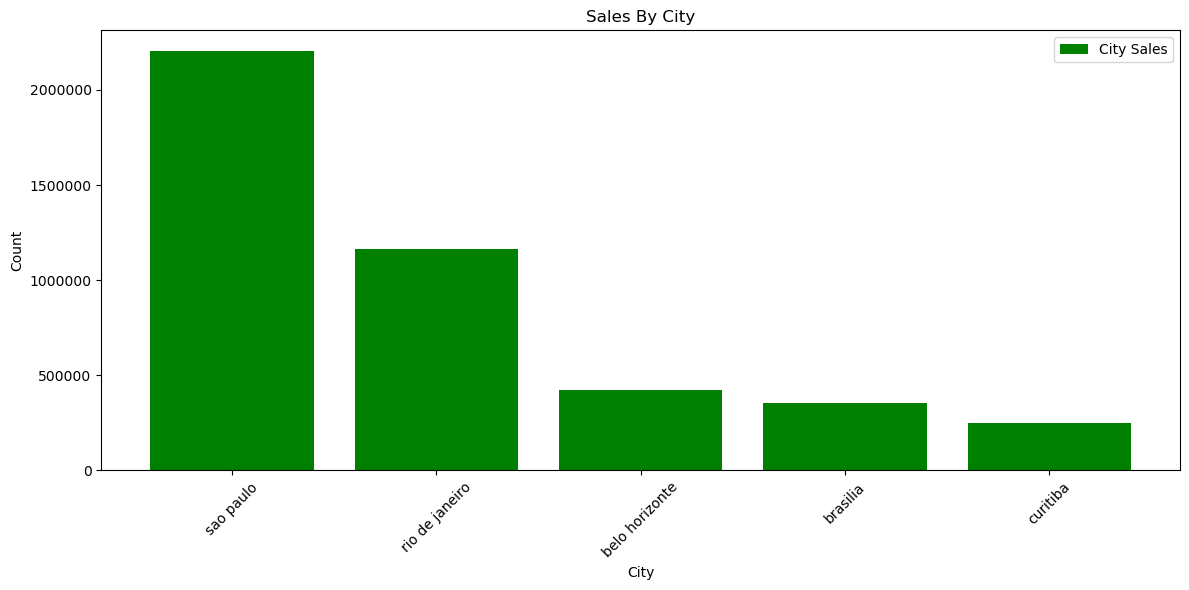

In [6]:
#similar code as above repeated for the sales data
connection_to_database = sqlite3.connect("Olist_DB.db")

try:
    total_spend_by_city_query = """
    WITH City_Sales_Data AS(
        SELECT *
        FROM olist_orders_dataset
        LEFT JOIN olist_customers_dataset
        USING(customer_id)
        LEFT JOIN olist_order_payments_dataset 
            ON olist_orders_dataset.order_id = olist_order_payments_dataset.order_id
        )
    SELECT customer_city, SUM(payment_value) AS total_sales
    FROM City_Sales_Data
    GROUP BY customer_city
    ORDER BY total_sales DESC
    LIMIT 5
    """

    total_spend_by_city = pd.read_sql_query(total_spend_by_city_query, connection_to_database)
    

    plt.figure(figsize=(12, 6)) 
    plt.bar(total_spend_by_city['customer_city'], total_spend_by_city['total_sales'], color='green', label='City Sales')
    plt.title('Sales By City')
    plt.xlabel('City')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend()
    
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.yaxis.get_major_formatter().set_scientific(False)
    
    plt.tight_layout()
    plt.show()
    
    
    
    
finally:
    connection_to_database.close()

## 4: Rating Data: 

I also wanted to see if the quality of the items sold, reflected by the user ratings, had any effect on the sales of items. A line graph is plotted to show the amount of sales, in dollars, of items by their average user rating scores. 

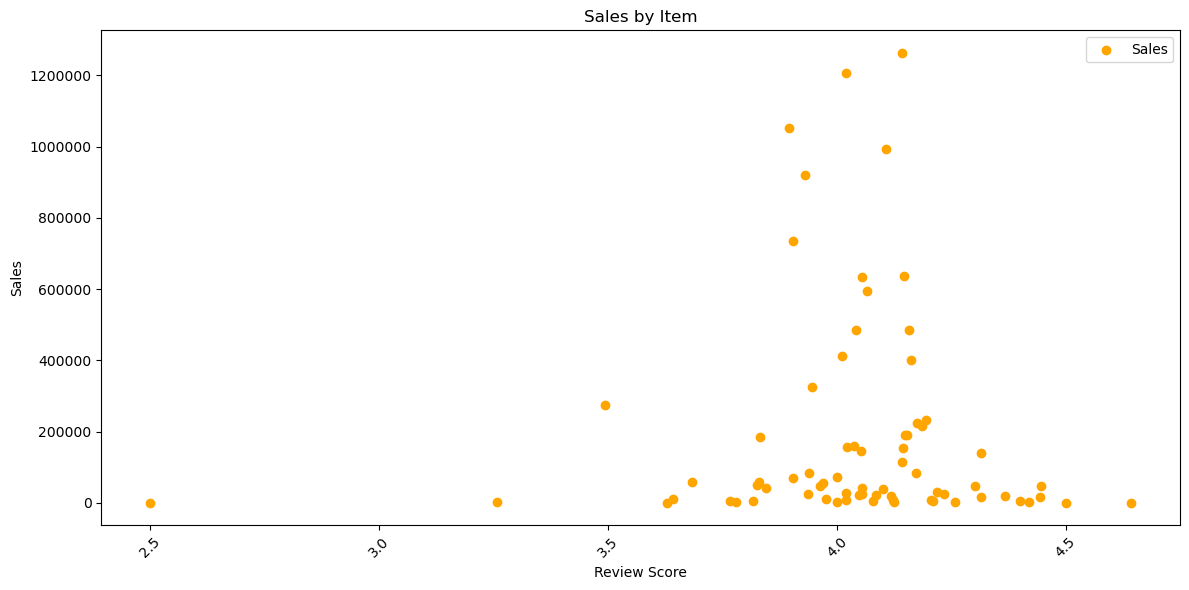

In [7]:
#Final visualization of ratings score

connection_to_database = sqlite3.connect("Olist_DB.db")

try:
    total_sale_and_rating_query = """
    SELECT product_category_name_english, SUM(order_item_id) AS total_items_sold, SUM(price) AS total_sales, AVG(review_score) AS Average_Score
    FROM olist_order_items_dataset
    LEFT JOIN olist_order_reviews_dataset
    USING(order_id)
    LEFT JOIN olist_products_dataset
    USING (product_id)
    LEFT JOIN product_category_name_translation
    USING(product_category_name)
    GROUP BY product_category_name_english
    ORDER BY total_items_sold DESC;
    """

    total_sale_and_rating = pd.read_sql_query(total_sale_and_rating_query, connection_to_database)
    

    plt.figure(figsize=(12, 6)) 
    plt.scatter(total_sale_and_rating['Average_Score'], total_sale_and_rating['total_sales'], color='orange', label='Sales')
    plt.title('Sales by Item')
    plt.xlabel('Review Score')
    plt.ylabel('Sales')
    plt.xticks(rotation=45)
    plt.legend()
    
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.xaxis.get_major_formatter().set_scientific(False)
    
    plt.tight_layout()
    plt.show()
    
    

    
    
finally:
    connection_to_database.close()

## 5: Overview

From the EDA conducted, it is apparent that the city placing the order has an effect on the outcome both in total items sold and the revenue generated from those items. Furthermore, since sales is ultimately what drives revenue for a business like Olist, we will want to put an extra emphasis on cities who not only buy a large quantity of items, but buy more high cost items. Finally, a suprsing outcome of the report is that the user rating seems to have a somewhat normal distribution. there is a large gathering of increased sales for products with average ratings slightly higher than 4.0, but we actually see a dip in sales for both very high and very low quality items. For next steps, another notebook is created attempting to combine some of our data using SQL and then model total sales. 